In [42]:
import pandas as pd
import dask.bag as db
import dask.dataframe as dd
import json
import datetime
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [43]:
processed_path = 'data/processed.json'

if os.path.exists(processed_path):
    with open(processed_path, encoding='utf-8', mode='r') as file:
        processed = json.load(file)
else:
    processed = []

In [44]:
all_posts = glob.glob('posts/file*.jsonl')

new_posts = list(set(all_posts).difference(processed))
posts = (db.read_text(new_posts)
           .map(json.loads))
n_posts = posts.map(lambda x: 1).sum()

In [49]:
s = posts.take(300)[-1]

In [5]:
n_posts_computed = n_posts.compute()
print("Number of posts, total", n_posts_computed)

Number of posts, total 227290


In [6]:
freq = posts.pluck('group').frequencies()

In [7]:
%%time
freq_comp = freq.compute()

CPU times: user 27.4 ms, sys: 41.9 ms, total: 69.3 ms
Wall time: 7.38 s


Text(0, 0.5, 'Group')

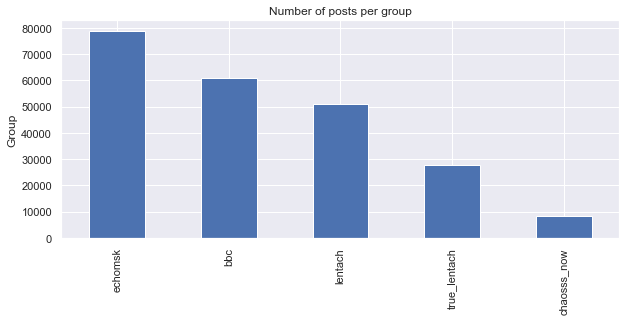

In [9]:
(pd.Series(dict(freq_comp))
   .sort_values(ascending=False)
   .plot
   .bar(figsize=(10, 4)))

plt.title('Number of posts per group')
plt.ylabel('Number of posts')
plt.ylabel("Group")

In [35]:
def flatten(x):
    y = {}
    y['group'] = x['group']
    y['date'] = x['date']
    y['text'] = x['text']
    y['likes'] = x['likes']['count']
    y['reposts'] = x['reposts']['count']
    y['user_reposts'] = x['reposts']
    y['views'] = x['views']['count'] if "views" in x else -1
    y['marked_as_ads'] = bool(x['marked_as_ads'])
    return y

posts_flattened = posts.map(flatten)

ddf = (posts_flattened.to_dataframe()
                      .astype({'group': 'category'})
                      .repartition(npartitions=12))

In [36]:
df = ddf.compute()
df.index = range(len(df))

In [37]:
mem_usg = df.memory_usage(deep=True) / 1024 ** 2
mem_usg

Index              0.000122
group              0.217223
date               1.734085
text             203.520060
likes              1.734085
reposts            1.734085
views              1.734085
marked_as_ads      0.216761
dtype: float64

In [39]:
!rm -rf data/news.parq

In [40]:
df.to_parquet('data/news.parq', partition_cols=['group'])

/Users/u17518516/.conda/envs/news-research/lib/python3.7/site-packages/pyarrow/pandas_compat.py:383: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  'start': level._start,
/Users/u17518516/.conda/envs/news-research/lib/python3.7/site-packages/pyarrow/pandas_compat.py:384: FutureWarning: RangeIndex._stop is deprecated and will be removed in a future version. Use RangeIndex.stop instead
  'stop': level._stop,
/Users/u17518516/.conda/envs/news-research/lib/python3.7/site-packages/pyarrow/pandas_compat.py:385: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  'step': level._step


In [18]:
with open('data/processed.json', encoding='utf-8', mode='w') as file:
    json.dump(all_posts, file)

In [41]:
! cat data/processed.json

["posts/file_true_lentach_2021-03-23.jsonl", "posts/file_currenttime_2021-03-24.jsonl", "posts/file_chaosss_now_2021-03-24.jsonl", "posts/file_echomsk_2021-03-24.jsonl", "posts/file_lentach_2021-03-24.jsonl", "posts/file_bbc_2021-03-23.jsonl"]